In [1]:
# -*- coding: utf-8 -*-
# Anaëlle Pierredon et Jianying Liu

"""
Ce notebook permet de faire des visualisations de nos fichiers résultats et notamment :

- Cas selon le type de MWE
- Cas selon le corpus
- Validation selon Cas + catégorie

- Vrais selon le type de MWE et le cas
- Quelque chose avec le degré ?

- Nombre d'expressions différentes (lemmes)
- VID les plus courantes
- LVC les plus courantes
- Répartitions de la validation de quelques expressions les plus courantes
"""

import re
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

barWidth = 0.20

# Définitions de fonctions

In [113]:
def infos_graphique(dataframe, liste_abs, str_groupe, str_elt):
    """
    Récupère les informations à afficher sous la forme d'un dictionnaire.
    
    Args:
        dataframe (df), dataframe où se trouvent les informations à récupérer
        liste_abs (liste de str), la liste des valeurs possibles en abscisse
        str_groupe (str), le nom de la colonne de la dataframe à récupérer pour l'abscisse
        str_elt (str), le nom de la colonne de la dataframe à récupérer pour les sous-valeurs de l'abscisse
    Returns:
        infos (dict), un dictionnaire avec en clé les sous-valeurs de l'abscisse et en valeurs des arrays de 
        la taille des valeurs possibles de l'abscisse avec les quantités correspondantes. 
    """
    # Taille de la figure
    plt.rcParams["figure.figsize"] = (16,10)

    # Ordre de l'élément en abscisse dans les arrays
    indices = {}
    for ind, abscisse in enumerate(liste_abs):
        indices[abscisse] = ind

    # Récupérer les infos pour le graphique
    infos = {}
    for ind in dataframe.index:
        abscisse = indices[dataframe[str_groupe][ind]]
        element = dataframe[str_elt][ind]
        if element in infos:
            infos[element][abscisse] += 1
        else:
            infos[element] = np.zeros(len(liste_abs))
            infos[element][abscisse] += 1
    return infos


def camembert_validation(dataframe, mwe):
    """
    Crée un camembert de la distribution des valeurs de validation pour la ou les expressions passées en argument.
    
    Args:
        dataframe (df), dataframe où se trouvent les informations à récupérer
        mwe (str), l'expression à représenter
    """
    # Taille de la figure
    plt.rcParams["figure.figsize"] = (5,5)

    # Ordre de l'élément dans les arrays
    indices = {}
    labels = dataframe["VALIDATION_SET"][mwe]
    for ind, abscisse in enumerate(labels):
        indices[abscisse] = ind
    
    # Récupérer les informations
    infos = np.zeros(len(labels))
    for val in dataframe["VALIDATION_LIST"][mwe]:
        ind = indices[val]
        infos[ind] += 1
    
    # Correspondance des couleurs
    labels_colors = {
        'vrai': 'greenyellow',
        'faux': 'tomato',
        'répétitions': 'mediumturquoise',
        'discutable': 'lightpink',
        'non concerné': 'lightgrey'
    }
    colors = [labels_colors[label] for label in labels]

    # Création du graphique
    fig, ax = plt.subplots()
    ax.pie(infos, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
    ax.axis('equal')
    ax.set_title(f"Répartition des valeurs de validation de l'expression \"{mwe}\"")
    plt.legend(labels, loc="best")

    plt.show()


def position_graphique(nb_etiquettes, colonnes, barWidth):
    """
    Déterminer la position des barres en fonction du nombre de valeurs possibles de l'abscisse et
    du nombre de sous-valeurs.
    
    Args:
        nb_etiquettes (int), nombre de valeurs possibles de l'abscisse
        colonnes (int), nombre de sous-valeurs possibles de l'abscisse
        barWidth, largeur des barres
    Returns:
        liste_positions (liste d'arrays), la liste des positions de chaque élément
        x (array), la position des étiquettes des abscisses
    """
    x = np.arange(nb_etiquettes)
    liste_positions = []
    for elt in range(0, colonnes):
        if elt == 0:
            liste_positions.append(x)
        else:
            liste_positions.append([x + barWidth for x in liste_positions[elt-1]])
    return liste_positions, x

# Lecture des fichiers

In [114]:
# Lecture des fichiers json et création d'un pandas dataframe contenant les résultats de tous les corpus
# Chaque ligne du dataframe correspond à une expression trouvée
liste_fichiers = []
liste_corpus = []
liste_types = []
df_resultats = pd.DataFrame()

for fichier in glob.glob("*_validation.json"):
    corpus = re.sub("_[0-9]+_validation.json", "", fichier)
    liste_corpus.append(corpus)
    with open(fichier, 'r') as json_file:
        data = json.load(json_file)
        for type_mwe in data:
            liste_types.append(type_mwe)
            dftmp = pd.DataFrame(data[type_mwe]['MWES'])
            dftmp["TYPE"] = type_mwe
            dftmp["CORPUS"] = corpus
            df_resultats = pd.concat([df_resultats, dftmp], ignore_index = True)
liste_types = list(set(liste_types))
df_resultats.tail(3)

,TYPE,CORPUS,FICHIER,PHRASE,TOKENS,COREF,CAS,CHAINE(S),VALIDATION,DEGRE DE COMPOSITIONNALITE,SOURCE D'ERREUR,LEMMES
1308,LVC.full,ancor_ESLO_CO2,CO2_ESLO_003_C_mwe_coref.cupt,alors il y a eu un il y a eu un intermède où p...,"['gardé', 'souvenir']","['*', '227:1903']",{'1903': 4},"{'227': '{'1903': ['un', 'souvenir', 'euh', 't...",vrai,,[],"[garder, souvenir]"
1309,LVC.full,ancor_ESLO_CO2,CO2_ESLO_003_C_mwe_coref.cupt,oui oui oui oui oui j' ai été au vingt-quatre ...,"['pris', 'photos']","['*', '255:2002']",{'2002': 4},"{'255': '{'1989': ['de', 'les', 'photos', 'de'...",vrai,,[],"[prendre, photo]"
1310,IRV,ancor_ESLO_CO2,CO2_ESLO_002_C_mwe_coref.cupt,sur la maquette oui voyez- vous ? parce que eu...,"['vous', 'mis']","['98:1138', '*']",{'1138': 3},"{'98': '{'1087': ['les', 'peintres'], '1092': ...",faux,,[MWE incorrecte],"[vous, mettre]"


In [115]:
# Vérifier les informations
liste_degres = list(set([df_resultats['DEGRE DE COMPOSITIONNALITE'][ind] for ind in df_resultats.index]))
print(f"CORPUS : {liste_corpus}")
print(f"TYPES : {liste_types}")
print(f"DEGRES : {liste_degres}")

CORPUS : ['sequoia_annodisER', 'ER_0-100', 'ancor_ESLO_ANCOR', 'ancor_UBS', 'ancor_OTG', 'sequoia_emea', 'sequoia_frwiki', 'ancor_ESLO_CO2']
TYPES : ['MVC', 'IRV', 'VID', 'LVC.full', 'LVC.cause']
DEGRES : ['', 'fort', 'moyen']


In [116]:
# Nombre d'expressions, Nombre de corpus, Corpus le plus courant
df_resultats["CORPUS"].describe()

count                 1311
unique                   8
top       ancor_ESLO_ANCOR
freq                   902
Name: CORPUS, dtype: object

# Graphiques sur les résultats globaux

In [117]:
# Minidf : cas - type - corpus - validation - degré de compositionnalité
# Minidf_2 : sans ANCOR et ER
# Chaque ligne correspond à un cas (parfois plusieurs cas pour une expression trouvée)
dico = {}
dico_2 = {}
cnt = 0
for ind in df_resultats.index:
    for cas in eval(df_resultats['CAS'][ind]).values():
        dico[cnt] = {"CAS": cas,
                     "TYPE": df_resultats['TYPE'][ind],
                     "CORPUS": df_resultats['CORPUS'][ind],
                     "VALIDATION": df_resultats['VALIDATION'][ind],
                     "DEGRE": df_resultats['DEGRE DE COMPOSITIONNALITE'][ind]}
        if "ancor_" not in df_resultats['CORPUS'][ind] and "ER_" not in df_resultats['CORPUS'][ind]:
            dico_2[cnt] = dico[cnt]
        cnt +=1
minidf_2 = pd.DataFrame(dico_2).T
minidf = pd.DataFrame(dico).T
minidf.head(10)

,CAS,TYPE,CORPUS,VALIDATION,DEGRE
0,3,VID,sequoia_annodisER,faux,
1,3,VID,sequoia_annodisER,faux,
2,4,VID,sequoia_annodisER,faux,
3,3,VID,sequoia_annodisER,faux,
4,3,VID,sequoia_annodisER,faux,
5,3,VID,sequoia_annodisER,faux,
6,3,VID,sequoia_annodisER,faux,
7,4,VID,sequoia_annodisER,faux,
8,3,VID,sequoia_annodisER,faux,
9,3,VID,sequoia_annodisER,faux,


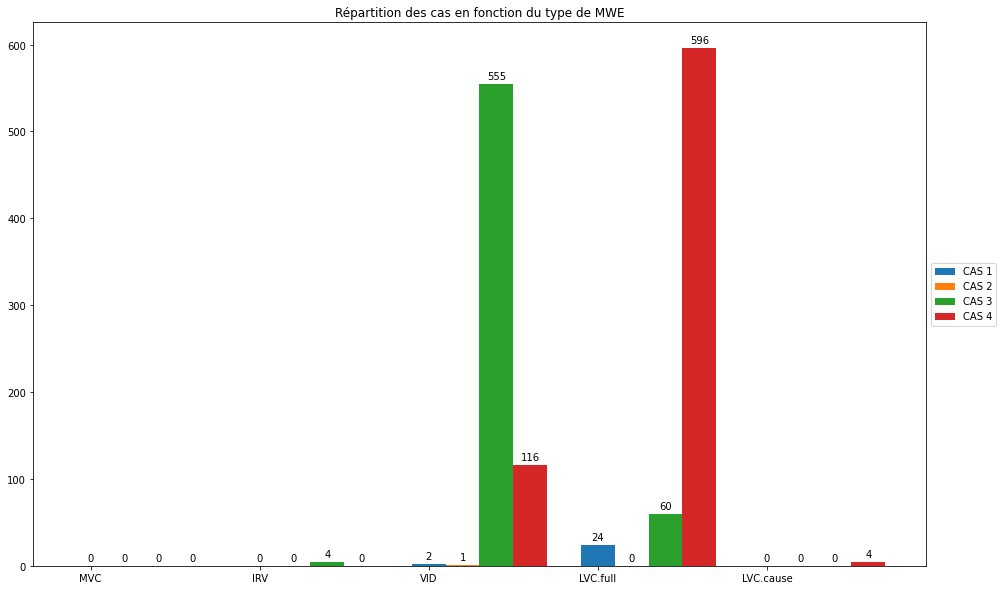

In [118]:
# Cas selon le type de MWE

# Récupérer les infos pour faire le graphique
infos = infos_graphique(minidf, liste_types, 'TYPE', 'CAS')

# Position des infos en abscisses
position, x = position_graphique(len(liste_types), len(infos), barWidth)

# Création du graphique
fig, ax = plt.subplots()
cnt = 0
for cas, type_arr in sorted(infos.items(), key=lambda t: t[0]):
    elt = ax.bar(position[cnt], type_arr, width=barWidth, label=f'CAS {cas}')
    ax.bar_label(elt, padding=3)
    cnt += 1
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticks(x)
ax.set_xticklabels(liste_types)
ax.set_title("Répartition des cas en fonction du type de MWE")

plt.show()

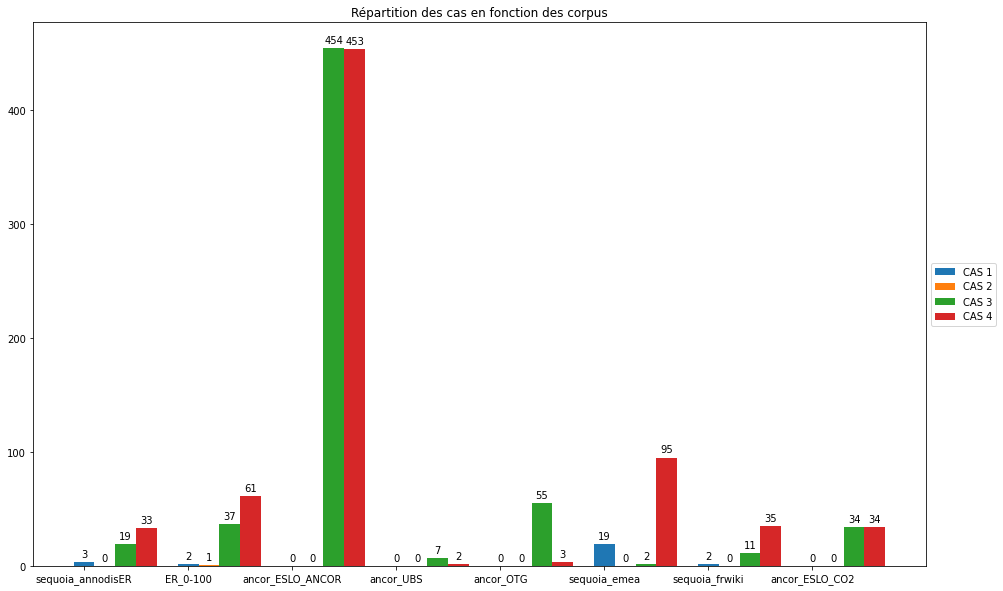

In [119]:
# Cas selon le corpus

# Récupérer les infos pour faire le graphique
infos = infos_graphique(minidf, liste_corpus, 'CORPUS', 'CAS')

# Position des infos en abscisses
position, x = position_graphique(len(liste_corpus), len(infos), barWidth)

# Création du graphique
fig, ax = plt.subplots()
cnt = 0
for cas, corpus_arr in sorted(infos.items(), key=lambda t: t[0]):
    elt = ax.bar(position[cnt], corpus_arr, width=barWidth, label=f'CAS {cas}')
    ax.bar_label(elt, padding=3)
    cnt += 1
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticks(x)
ax.set_xticklabels(liste_corpus)
ax.set_title("Répartition des cas en fonction des corpus")

plt.show()

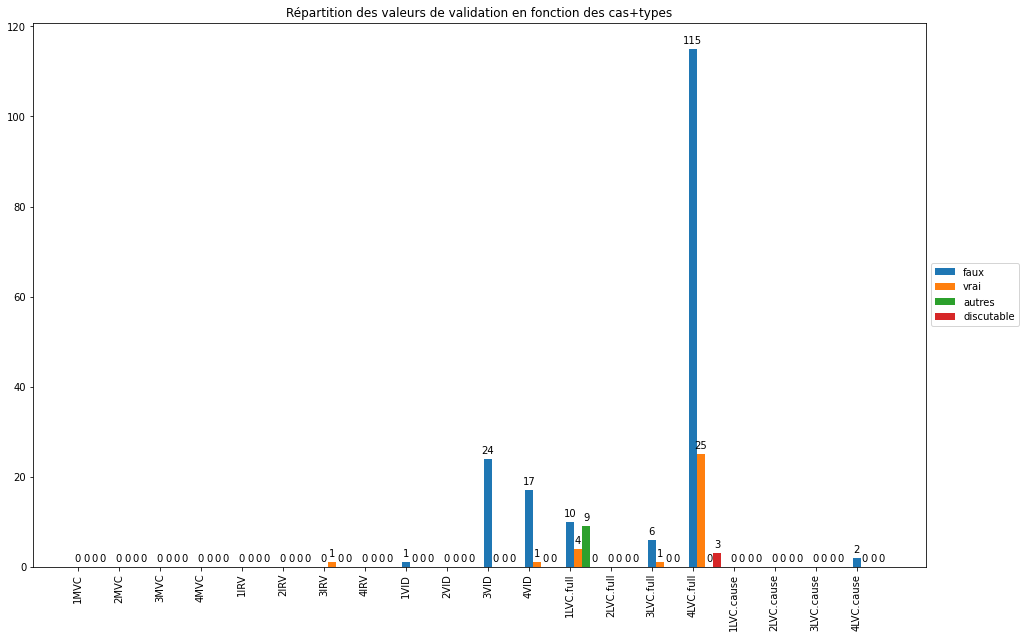

In [120]:
# Validation selon Cas + type
# Pour tous les corpus dont l'annotation en MWE est fiable et
# l'erreur porte forcément sur les mentions ou les chaînes

# Création de la liste des cas + type
liste_castypes = []
for type_mwe in liste_types:
    liste_castypes.extend([f"1{type_mwe}", f"2{type_mwe}", f"3{type_mwe}", f"4{type_mwe}"])

# Ordre des castypes dans les arrays
indices = {}
for ind, castype in enumerate(liste_castypes):
    indices[castype] = ind

# Récupérer les infos pour le graphique
infos = {}
for ind in minidf_2.index:
    val = minidf_2['VALIDATION'][ind]
    if val not in ["vrai", "faux", "discutable"]:
        val = "autres"
    castype = indices[f"{minidf_2['CAS'][ind]}{minidf_2['TYPE'][ind]}"]
    if val in infos:
        infos[val][castype] += 1
    else:
        infos[val] = np.zeros(len(liste_castypes))
        infos[val][castype] += 1

# Position des infos en abscisses
position, x = position_graphique(len(liste_castypes), len(infos), barWidth)

# Création du graphique
fig, ax = plt.subplots()
cnt = 0
for val, castype_arr in infos.items():
    elt = ax.bar(position[cnt], castype_arr, width=barWidth, label=val)
    ax.bar_label(elt, padding=3)
    cnt += 1
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticks(x)
ax.set_xticklabels(liste_castypes)
ax.set_title("Répartition des valeurs de validation en fonction des cas+types")

plt.xticks(rotation=90)
plt.show()

# Graphiques sur les résultats corrects 

In [121]:
# vraidf : cas - type - corpus - degré de compositionnalité
# Seuls les exemples annotés comme "vrai" (VALIDATION) sont conservés
# Chaque ligne correspond à un cas (parfois plusieurs cas pour une expression trouvée)
dico = {}
cnt = 0
for ind in minidf.index:
    if minidf['VALIDATION'][ind] == "vrai":
        dico[cnt] = {"CAS": minidf['CAS'][ind],
                     "TYPE": minidf['TYPE'][ind],
                     "CORPUS": minidf['CORPUS'][ind],
                     "DEGRE": minidf['DEGRE'][ind]}
        cnt +=1
vraidf = pd.DataFrame(dico).T
vraidf.head(10)

,CAS,TYPE,CORPUS,DEGRE
0,4,LVC.full,sequoia_annodisER,fort
1,4,LVC.full,ER_0-100,fort
2,4,LVC.full,ER_0-100,fort
3,4,LVC.full,ER_0-100,fort
4,4,LVC.full,ER_0-100,fort
5,4,LVC.cause,ancor_ESLO_ANCOR,
6,4,VID,ancor_ESLO_ANCOR,
7,3,VID,ancor_ESLO_ANCOR,
8,3,VID,ancor_ESLO_ANCOR,
9,4,VID,ancor_ESLO_ANCOR,


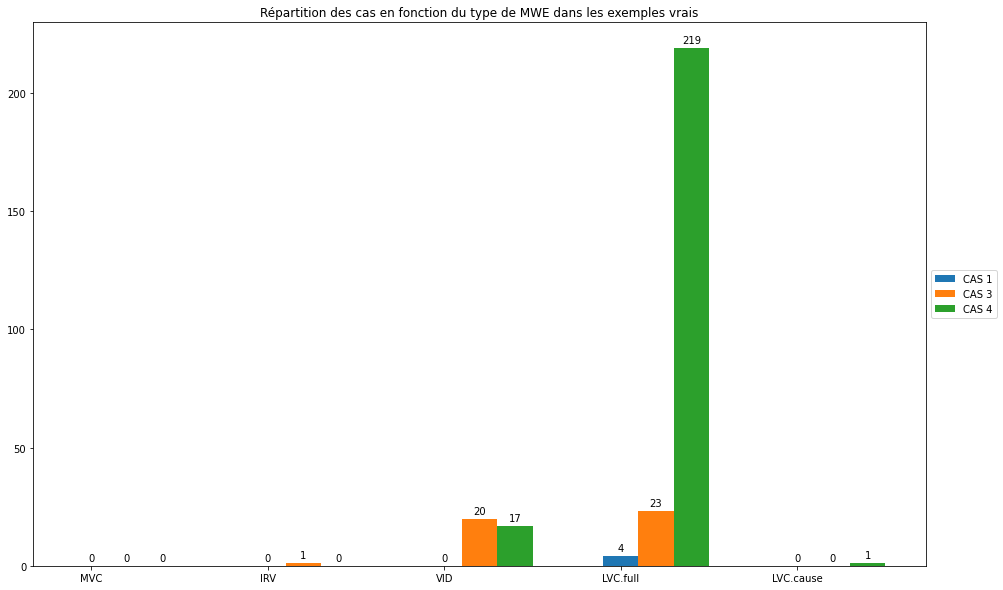

In [122]:
# Vrais selon le type de MWE et du cas

# Récupérer les infos pour faire le graphique
infos = infos_graphique(vraidf, liste_types, 'TYPE', 'CAS')

# Position des infos en abscisses
position, x = position_graphique(len(liste_types), len(infos), barWidth)

# Création du graphique
fig, ax = plt.subplots()
cnt = 0
for cas, type_arr in sorted(infos.items(), key=lambda t: t[0]):
    elt = ax.bar(position[cnt], type_arr, width=barWidth, label=f'CAS {cas}')
    ax.bar_label(elt, padding=3)
    cnt += 1
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticks(x)
ax.set_xticklabels(liste_types)
ax.set_title("Répartition des cas en fonction du type de MWE dans les exemples vrais")

plt.show()

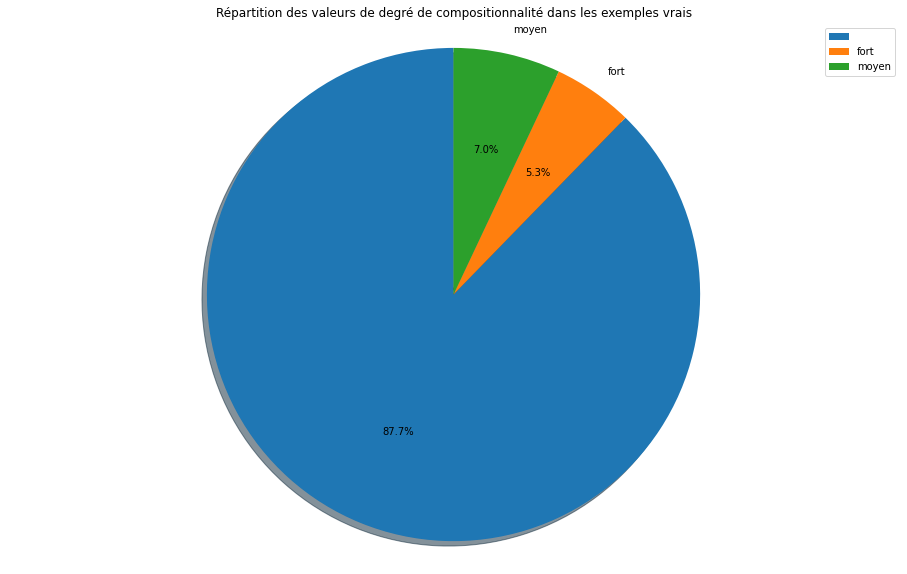

In [125]:
# Répartition des valeurs de degré de compositionnalité

# Ordre de l'élément dans les arrays
indices = {}
for ind, degre in enumerate(liste_degres):
    indices[degre] = ind

# Récupérer les informations
infos = np.zeros(len(liste_degres))
for ind in vraidf.index:
    ind = indices[vraidf["DEGRE"][ind]]
    infos[ind] += 1

# Création du graphique
fig, ax = plt.subplots()
ax.pie(infos, labels=liste_degres, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title(f"Répartition des valeurs de degré de compositionnalité dans les exemples vrais")
plt.legend(liste_degres, loc="best")
plt.show()


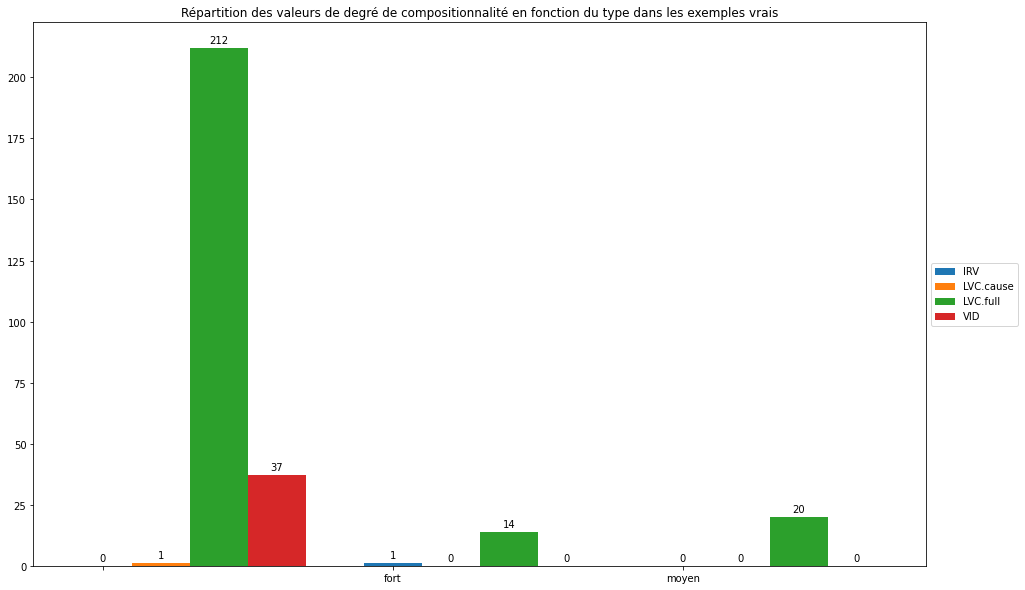

In [126]:
# Répartition du degré de compositionnalité en fonction du cas

# Récupérer les infos pour faire le graphique
infos = infos_graphique(vraidf, liste_degres, 'DEGRE', 'TYPE')

# Position des infos en abscisses
position, x = position_graphique(len(liste_degres), len(infos), barWidth)

# Création du graphique
fig, ax = plt.subplots()
cnt = 0
for type_mwe, degre_arr in sorted(infos.items(), key=lambda t: t[0]):
    elt = ax.bar(position[cnt], degre_arr, width=barWidth, label=type_mwe)
    ax.bar_label(elt, padding=3)
    cnt += 1
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticks(x)
ax.set_xticklabels(liste_degres)
ax.set_title("Répartition des valeurs de degré de compositionnalité en fonction du type dans les exemples vrais")

plt.show()

# Graphiques sur les expressions polylexicales

In [18]:
# mwedf : lemmes - type - validation_set(ensemble) - validation_list(liste) - degré de compositionnalité(liste) -
# corpus(liste) - Quantité
# mwedf_2 : seulement ANCOR et ER
# Chaque ligne correspond à une expression lemmatisée

dico = {}
dico_2 = {}

for ind in df_resultats.index:
    expression = ' '.join(df_resultats['LEMMES'][ind])
            
    if expression not in dico:
        dico[expression] = { "TYPE": "",
                             "VALIDATION_SET": [],
                             "VALIDATION_LIST": [],
                             "DEGRE": [],
                             "CORPUS": [],
                             "QUANTITE": 0
                            }

    dico[expression]["TYPE"] = df_resultats['TYPE'][ind]
    if df_resultats['VALIDATION'][ind] not in dico[expression]["VALIDATION_SET"]:
        dico[expression]["VALIDATION_SET"].append(df_resultats['VALIDATION'][ind])
    dico[expression]["VALIDATION_LIST"].append(df_resultats['VALIDATION'][ind])
    if df_resultats['DEGRE DE COMPOSITIONNALITE'][ind] != "":
        dico[expression]["DEGRE"].append(df_resultats['DEGRE DE COMPOSITIONNALITE'][ind])
    if df_resultats['DEGRE DE COMPOSITIONNALITE'][ind] not in dico[expression]["CORPUS"]:
        dico[expression]["CORPUS"].append(df_resultats['CORPUS'][ind])
    dico[expression]["QUANTITE"] += 1

    if "ancor_" in df_resultats['CORPUS'][ind] or "ER_" in df_resultats['CORPUS'][ind]:
        dico_2[expression] = dico[expression]
        
mwedf_2 = pd.DataFrame(dico_2).T
mwedf = pd.DataFrame(dico).T
mwedf.head(10)

,TYPE,VALIDATION_SET,VALIDATION_LIST,DEGRE,CORPUS,QUANTITE
prendre en compte,VID,[faux],[faux],[],[sequoia_annodisER],1
perdre connaissance,VID,[faux],[faux],[],[sequoia_annodisER],1
répondre à le nom,VID,[faux],[faux],[],[sequoia_annodisER],1
mettre à le point,VID,[faux],[faux],[],[sequoia_annodisER],1
donner signe de vie,VID,[faux],[faux],[],[sequoia_annodisER],1
être le occasion,VID,[faux],"[faux, faux, faux]",[],"[sequoia_annodisER, ER_0-100, ER_0-100]",3
revoir à le baisse,VID,[faux],"[faux, faux]",[],"[sequoia_annodisER, sequoia_frwiki]",2
prendre son responsabilité,VID,[faux],[faux],[],[sequoia_annodisER],1
en faire autant,VID,[faux],[faux],[],[sequoia_annodisER],1
faire le objet,VID,[faux],"[faux, faux]",[],"[sequoia_annodisER, sequoia_frwiki]",2


In [19]:
# Nombre d'expressions différentes (lemmes)
sup_un = [ind for ind in mwedf.index if mwedf["QUANTITE"][ind] > 1]
sup_cinq = [ind for ind in mwedf.index if mwedf["QUANTITE"][ind] > 5]
sup_dix = [ind for ind in mwedf.index if mwedf["QUANTITE"][ind] > 10]
sup_cinquante = [ind for ind in mwedf.index if mwedf["QUANTITE"][ind] > 50]
sup_cent = [ind for ind in mwedf.index if mwedf["QUANTITE"][ind] > 100]

print(f"Il y a {len(mwedf.index)} expressions différentes.")
print(f"Il y a {len(sup_un)} expressions différentes dont le nombre d'occurrence est supérieur à 1.")
print(f"Il y a {len(sup_cinq)} expressions différentes dont le nombre d'occurrence est supérieur à 5.")
print(f"\nIl y a {len(sup_dix)} expressions différentes dont le nombre d'occurrence est supérieur à 10 :")
for mwe in sup_dix:
    print(f"- {mwe}")
print(f"\nIl y a {len(sup_cinquante)} expressions différentes dont le nombre d'occurrence est supérieur à 50 :")
for mwe in sup_cinquante:
    print(f"- {mwe}")
print(f"\nIl y a {len(sup_cent)} expressions différentes dont le nombre d'occurrence est supérieur à 100 :")
for mwe in sup_cent:
    print(f"- {mwe}")
        

Il y a 352 expressions différentes.
Il y a 137 expressions différentes dont le nombre d'occurrence est supérieur à 1.
Il y a 30 expressions différentes dont le nombre d'occurrence est supérieur à 5.

Il y a 16 expressions différentes dont le nombre d'occurrence est supérieur à 10 :
- faire grève
- lui poser question
- il rester
- en avoir
- avoir le temps
- faire ça
- ça faire
- faire son temps
- faire travail
- faire étude
- avoir question
- avoir difficulté
- poser question
- prendre sanction
- avoir problème
- avoir classe

Il y a 3 expressions différentes dont le nombre d'occurrence est supérieur à 50 :
- en avoir
- ça faire
- faire étude

Il y a 1 expressions différentes dont le nombre d'occurrence est supérieur à 100 :
- en avoir


In [23]:
# VID et LVC.full les plus courantes
vid = {}
lvcfull = {}
for mwe in mwedf.index:
    if mwedf['TYPE'][mwe] == "VID":
        vid[mwe] = mwedf['QUANTITE'][mwe]
    if mwedf['TYPE'][mwe] == "LVC.full":
        lvcfull[mwe] = mwedf['QUANTITE'][mwe]
vid = sorted(vid, key=vid.get, reverse=True)[:10]
lvcfull = sorted(lvcfull, key=lvcfull.get, reverse=True)[:10]

print("Les VID les plus courantes sont :")
for mwe in vid:
    print(f"- {mwe}\t{mwedf['QUANTITE'][mwe]}")

print("\nLes LVC.full les plus courantes sont :")
for mwe in lvcfull:
    print(f"- {mwe}\t{mwedf['QUANTITE'][mwe]}")


Les VID les plus courantes sont :
- en avoir	279
- ça faire	74
- avoir le temps	40
- faire ça	37
- il rester	18
- lui poser question	12
- faire son temps	11
- avoir raison	10
- en vouloir	7
- il y avoir	7

Les LVC.full les plus courantes sont :
- faire étude	57
- avoir problème	29
- faire travail	27
- avoir difficulté	22
- faire grève	21
- poser question	19
- avoir question	15
- prendre sanction	15
- avoir classe	14
- faire effort	10


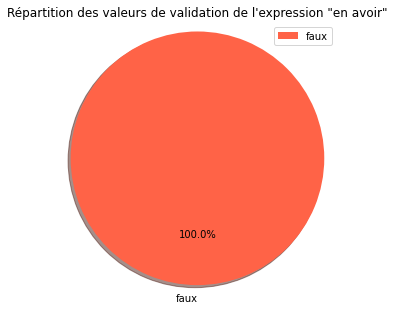

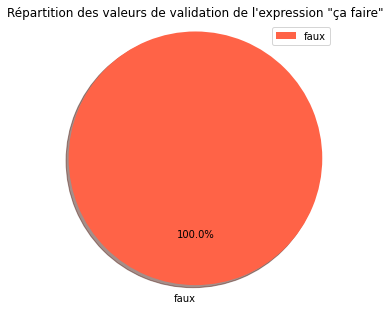

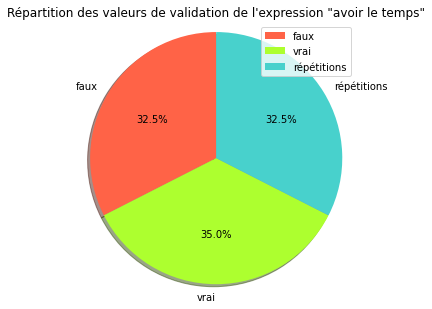

In [95]:
# Répartitions de la validation des 3 VID les plus courantes
# en avoir / cela faire / avoir le temps

camembert_validation(mwedf_2, "en avoir")
camembert_validation(mwedf_2, "ça faire")
camembert_validation(mwedf_2, "avoir le temps")

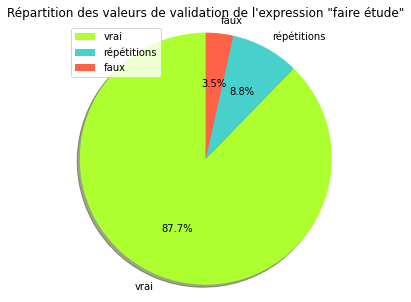

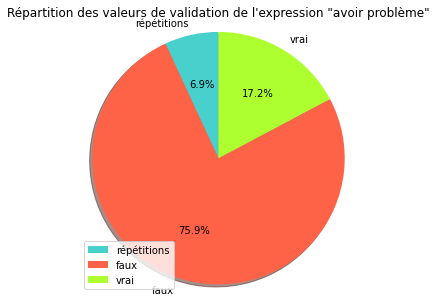

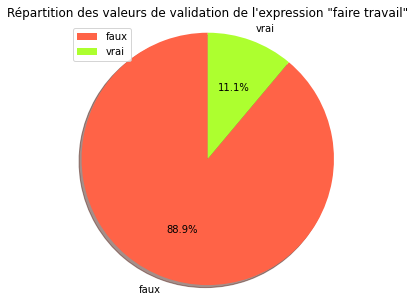

In [94]:
# Répartitions de la validation des 3 LVC.full les plus courantes
# subir icp / atteindre insuffisance / avoir problème ou problem

camembert_validation(mwedf_2, "faire étude")
camembert_validation(mwedf_2, "avoir problème")
camembert_validation(mwedf_2, "faire travail")